#Machine Learning Prediction in Tracking Product Delivery

#Import Libraries

In [1]:
!pip install scikit-learn==0.24.1

     |████████████████████████████████| 22.3MB 1.6MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
pip install -U imbalanced-learn

     |████████████████████████████████| 215kB 7.0MB/s 
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [3]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score

#Model Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix , classification_report, f1_score,\
                            accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

SEED = 0 

#Loading the Data

In [4]:
df = pd.read_csv("E-Commerce Shipping Data-c.csv")
df.head(10)

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached_on_Time
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1
5,6,F,Flight,3,1,162,3,medium,F,12,1417,1
6,7,D,Flight,3,4,250,3,low,F,3,2371,1
7,8,F,Flight,4,1,233,2,low,F,48,2804,1
8,9,A,Flight,3,4,150,3,low,F,11,1861,1
9,10,B,Flight,3,2,164,3,medium,F,29,1187,1


In [5]:
print(df.groupby('Mode_of_Shipment')\
    .ID.count()\
    .reset_index())

  Mode_of_Shipment    ID
0           Flight  1777
1             Road  1760
2             Ship  7462


In [ ]:
df['Reached_on_Time'].value_counts()

1    6563
0    4436
Name: Reached_on_Time, dtype: int64

In [ ]:
#pd.pivot_table(df, index=['Mode_of_Shipment','Cost_of_the_Product'], aggfunc='mean')
pd.pivot_table(df, index=['Mode_of_Shipment','Cost_of_the_Product'])

Customer_care_calls  ...  Weight_in_gms
Mode_of_Shipment Cost_of_the_Product                       ...               
Flight           96                              4.500000  ...    3319.500000
                 97                              4.000000  ...    2907.500000
                 98                              3.500000  ...    2474.500000
                 99                              5.000000  ...    4259.000000
                 101                             3.000000  ...    4275.000000
...                                                   ...  ...            ...
Ship             306                             6.307692  ...    1493.923077
                 307                             6.100000  ...    1629.300000
                 308                             6.583333  ...    1278.250000
                 309                             6.222222  ...    1669.111111
                 310                             6.538462  ...    1539.615385

[627 rows x 7 columns]

In [ ]:
#only can use in jupitar notebook
pip install xlwings

  Using cached https://files.pythonhosted.org/packages/a3/01/c1ccae64b8a09acc4b286d7919b5d1b5c9c968818713566920a0ad793e99/xlwings-0.23.3.tar.gz
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [ ]:
#only can use in jupitar notebook
import xlwings as xw
def run_excel_macro(file_path):
    """
    Execute an Excel macro
    :param file_path: path to the Excel file holding the macro
    :return: None
    """

    try:
        xl_app = xw.App(visible=False, add_book=False)
        wb = xl_app.books.open(file_path)

        run_macro = wb.app.macro('main.SimpleMain')
        run_macro()

        wb.save()
        wb.close()

        xl_app.quit()

    except Exception as ex:
        template = "An exception of type {0} occurred. Arguments:\n{1!r}"
        message = template.format(type(ex).__name__, ex.args)
        print(message)


run_excel_macro(input('Please enter Excel macro file path: '))

In [ ]:
df.columns

Index(['ID', 'Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms',
       'Reached_on_Time'],
      dtype='object')

#Data Pre-processing and Exploratory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached_on_Time      10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [ ]:
df.describe()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached_on_Time
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,3175.28214,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,1.00000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,2750.50000,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,5500.00000,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,8249.50000,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,10999.00000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


In [ ]:
# Let us first clean our data
# 1) Look for any missing values
df.isna().any()

ID                     False
Warehouse_block        False
Mode_of_Shipment       False
Customer_care_calls    False
Customer_rating        False
Cost_of_the_Product    False
Prior_purchases        False
Product_importance     False
Gender                 False
Discount_offered       False
Weight_in_gms          False
Reached_on_Time        False
dtype: bool

In [ ]:
# if have empty data
df = df.dropna()

In [ ]:
# Convert the Reached_on_Time column from int64 to object
df['Reached_on_Time']= df['Reached_on_Time'].apply(lambda x : 'Yes' if x == 0 else 'No')


In [ ]:
# Convert the Product_importance column from object to int64, Ordinal data
#df['Product_importance']= df['Product_importance'].apply(lambda x : '1' if x == 'low' 
                                                   #else ('2' if x == 'medium'
                                                        #else ('3')))

In [ ]:
# count number of items for each unique numberical feature
df.nunique()

ID                     10999
Warehouse_block            5
Mode_of_Shipment           3
Customer_care_calls        6
Customer_rating            5
Cost_of_the_Product      215
Prior_purchases            8
Product_importance         3
Gender                     2
Discount_offered          65
Weight_in_gms           4034
Reached_on_Time            2
dtype: int64

In [ ]:
df.head(10)

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached_on_Time
0,1,D,Flight,4,2,177,3,low,F,44,1233,No
1,2,F,Flight,4,5,216,2,low,M,59,3088,No
2,3,A,Flight,2,2,183,4,low,M,48,3374,No
3,4,B,Flight,3,3,176,4,medium,M,10,1177,No
4,5,C,Flight,2,2,184,3,medium,F,46,2484,No
5,6,F,Flight,3,1,162,3,medium,F,12,1417,No
6,7,D,Flight,3,4,250,3,low,F,3,2371,No
7,8,F,Flight,4,1,233,2,low,F,48,2804,No
8,9,A,Flight,3,4,150,3,low,F,11,1861,No
9,10,B,Flight,3,2,164,3,medium,F,29,1187,No


#Balancing dataset

https://towardsdatascience.com/5-smote-techniques-for-oversampling-your-imbalance-data-b8155bdbe2b5

https://python-bloggers.com/2020/12/how-to-effortlessly-handle-class-imbalance-with-python-and-smote/

In [ ]:
# Drop unnecessary columns
# Since the ID column is unique, we will drop the column
df = df.drop('ID', axis=1)
df = df.drop('Customer_rating', axis=1)

In [ ]:
df.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached_on_Time
0,D,Flight,4,177,3,low,F,44,1233,No
1,F,Flight,4,216,2,low,M,59,3088,No
2,A,Flight,2,183,4,low,M,48,3374,No
3,B,Flight,3,176,4,medium,M,10,1177,No
4,C,Flight,2,184,3,medium,F,46,2484,No


In [ ]:
X = df.drop('Reached_on_Time', axis=1)
y = df['Reached_on_Time']

#Import the SMOTE-NC
from imblearn.over_sampling import SMOTENC
#Create the oversampler. For SMOTE-NC we need to pinpoint the column position where is the categorical features are. If you have more than one categorical columns, just input all the columns position
smotenc = SMOTENC(categorical_features=[0,1,5,6], random_state = SEED)
X_sm, y_sm = smotenc.fit_resample(X, y)

#from imblearn.over_sampling import SMOTE 
#sm = SMOTE(random_state=SEED)
#X_sm, y_sm = sm.fit_resample(X, y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (10999, 9)
Shape of X after SMOTE: (13126, 9)

Balance of positive and negative classes (%):


No     50.0
Yes    50.0
Name: Reached_on_Time, dtype: float64

In [ ]:
#concat 2 series into dataframe
df =  pd.concat([X_sm, y_sm], axis=1)

In [ ]:
#save in csv
df.to_csv('Oversample.csv', index=False)

In [ ]:
df

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached_on_Time
0,D,Flight,4,177,3,low,F,44,1233,No
1,F,Flight,4,216,2,low,M,59,3088,No
2,A,Flight,2,183,4,low,M,48,3374,No
3,B,Flight,3,176,4,medium,M,10,1177,No
4,C,Flight,2,184,3,medium,F,46,2484,No
...,...,...,...,...,...,...,...,...,...,...
13121,B,Ship,6,141,3,low,F,3,1173,Yes
13122,F,Ship,3,145,2,medium,M,9,4363,Yes
13123,C,Ship,4,219,4,low,F,5,4095,Yes
13124,D,Ship,4,256,2,medium,M,3,4455,Yes


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


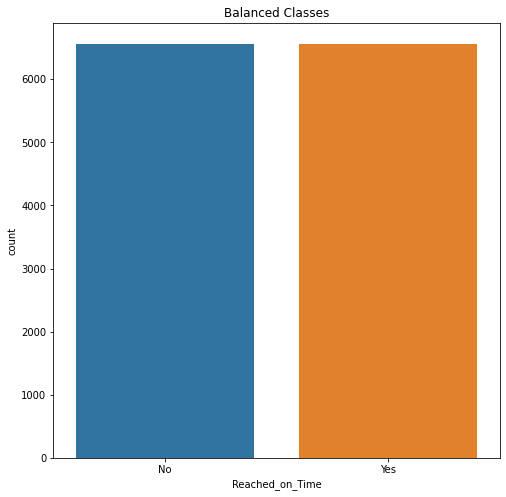

In [ ]:
#plot the dataset after the oversampling
plt.figure(figsize=(8, 8))
sns.countplot('Reached_on_Time', data=df)
plt.title('Balanced Classes')
plt.show()

In [ ]:
df['Reached_on_Time'].value_counts()

No     6563
Yes    6563
Name: Reached_on_Time, dtype: int64

#Defining the data

In [ ]:
df.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached_on_Time
0,D,Flight,4,177,3,low,F,44,1233,No
1,F,Flight,4,216,2,low,M,59,3088,No
2,A,Flight,2,183,4,low,M,48,3374,No
3,B,Flight,3,176,4,medium,M,10,1177,No
4,C,Flight,2,184,3,medium,F,46,2484,No


#####Ordinal Data

In [ ]:
# Select columns that are ordinal categorical i.e. product importance
X_cat_ord = df[['Product_importance']]

#Check for documentation of Ordinal Encoding https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html
#apply Ordinal Encoding accordingly:
from sklearn.preprocessing import OrdinalEncoder # for encoding categorical features from strings to number arrays
X_cat_nom_ord = OrdinalEncoder()
X_cat_ord = X_cat_nom_ord.fit_transform(X_cat_ord)

In [ ]:
#https://www.kite.com/python/answers/how-to-create-pandas-dataframe-from-a-numpy-array-in-python

X_cat_ord = pd.DataFrame(data=X_cat_ord, columns=["Product_importance"])
X_cat_ord = X_cat_ord.sort_index(ascending=True)

In [ ]:
X_cat_ord.head(5)

,Product_importance
0,1.0
1,1.0
2,1.0
3,2.0
4,2.0


In [ ]:
print(type(X_cat_ord))

<class 'pandas.core.frame.DataFrame'>


#####Nominal Data

In [ ]:
# Encoding the data - Before training the model, we need to make sure the data is in a form that the model can understand
# Use Label Encoder for all features with 2 classes
le = LabelEncoder()
for x in [i for i in df.columns if len(df[i].unique())==2]:
    print(x, df[x].unique())
    df[x]= le.fit_transform(df[x])

Gender ['F' 'M']
Reached_on_Time ['No' 'Yes']


In [ ]:
# Remap to integers
# df['Gender'] = [0 if x == 'M' else 1 for x in df['Gender']]

# Create dummy variables
dummy_Warehouse_block = pd.get_dummies(df['Warehouse_block'], prefix='Warehouse_block')
dummy_Mode_of_Shipment = pd.get_dummies(df['Mode_of_Shipment'], prefix='Mode_of_Shipment')

to_drop = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance']
df.drop(to_drop, axis=1, inplace=True)

In [ ]:
# Merge into a single data frame
df = pd.concat([dummy_Warehouse_block, dummy_Mode_of_Shipment, X_cat_ord, df], axis=1)

In [ ]:
df

,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance,Customer_care_calls,Cost_of_the_Product,Prior_purchases,Gender,Discount_offered,Weight_in_gms,Reached_on_Time
0,0,0,0,1,0,1,0,0,1.0,4,177,3,0,44,1233,0
1,0,0,0,0,1,1,0,0,1.0,4,216,2,1,59,3088,0
2,1,0,0,0,0,1,0,0,1.0,2,183,4,1,48,3374,0
3,0,1,0,0,0,1,0,0,2.0,3,176,4,1,10,1177,0
4,0,0,1,0,0,1,0,0,2.0,2,184,3,0,46,2484,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13121,0,1,0,0,0,0,0,1,1.0,6,141,3,0,3,1173,1
13122,0,0,0,0,1,0,0,1,2.0,3,145,2,1,9,4363,1
13123,0,0,1,0,0,0,0,1,1.0,4,219,4,0,5,4095,1
13124,0,0,0,1,0,0,0,1,2.0,4,256,2,1,3,4455,1


#Correlation Plot


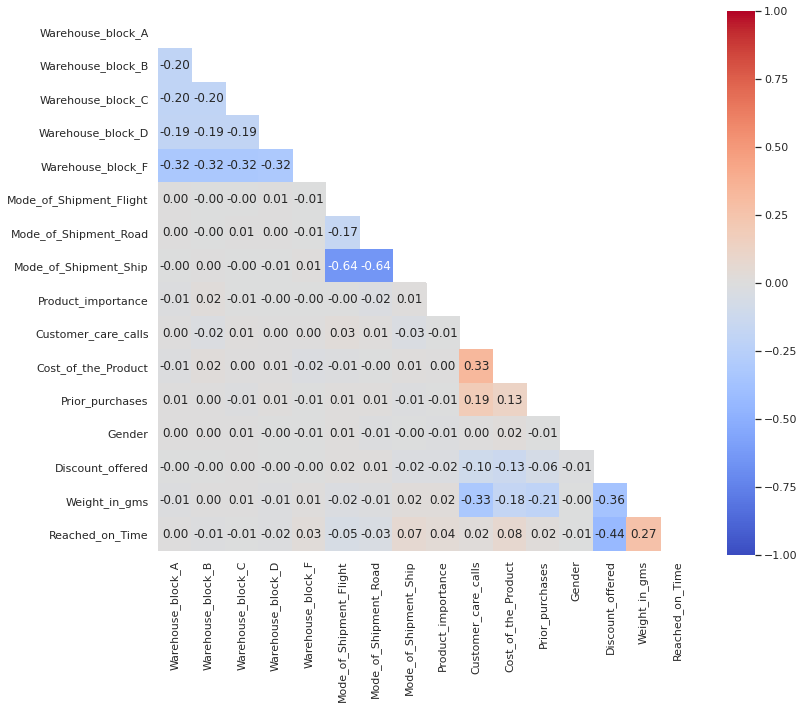

In [ ]:
# how strong the relation between variable 
# correlation matrix heatmap visualization
sns.set(style="white")

# Generate a mask for the upper triangle
matrix = np.triu(df.corr())

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(12,10))

# Plot the heatmap
_ = sns.heatmap(df.corr(), mask=matrix, annot=True, annot_kws={"size": 12}, square=True, 
                cmap='coolwarm' , vmin=-1, vmax=1, fmt='.2f')  # annot=True display corr label

# _ = sns.heatmap(df.corr(), annot=True, annot_kws={"size": 12}, square=True, 
#                 cmap='coolwarm' , vmin=-1, vmax=1, fmt='.2f')

# Prevent Heatmap Cut-Off Issue
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom+0.5, top-0.5)

#Feature Selection by using SelectKBest

In [ ]:
X=df.drop('Reached_on_Time',axis=1)
y=df['Reached_on_Time']


In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression
# For classifications, use 'chi2' score function
selectClf = SelectKBest(chi2, k=8)
X_new = selectClf.fit_transform(X, y)
X_new.shape


(13126, 8)

In [ ]:
mask = selectClf.get_support() #list of booleans
feature_names = list(X.columns.values)
new_features = [] # The list of your K best features

for booltype, feature in zip(mask, feature_names):
    if booltype:
        new_features.append(feature)

In [ ]:
new_features

['Warehouse_block_F',
 'Mode_of_Shipment_Flight',
 'Mode_of_Shipment_Road',
 'Mode_of_Shipment_Ship',
 'Product_importance',
 'Cost_of_the_Product',
 'Discount_offered',
 'Weight_in_gms']

In [ ]:
#original features
feature_names

['Warehouse_block_A',
 'Warehouse_block_B',
 'Warehouse_block_C',
 'Warehouse_block_D',
 'Warehouse_block_F',
 'Mode_of_Shipment_Flight',
 'Mode_of_Shipment_Road',
 'Mode_of_Shipment_Ship',
 'Product_importance',
 'Customer_care_calls',
 'Cost_of_the_Product',
 'Prior_purchases',
 'Gender',
 'Discount_offered',
 'Weight_in_gms']

##Remove column for Feature selection 
dropping columns except new_features

In [ ]:
columns = ['Customer_care_calls', 'Prior_purchases', 'Warehouse_block_A', 
           'Warehouse_block_B', 'Warehouse_block_C', 'Warehouse_block_D', 
           'Gender','Reached_on_Time']
X= df.drop(columns, axis=1)

y=df['Reached_on_Time']

# Split the data and train the models

In [ ]:
# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = SEED) #0.20-20% test data

In [ ]:
#train data
#X_train.head(10)
print(len(X_train))

#test data
#X_test.head(10)
print(len(X_test))

10500
2626


**Scaling** - Normalize the Data

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

# Now apply the transformations to the data:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

####Baseline model using Logistic Regression (without hyperparameter)

In [ ]:
logreg = LogisticRegression()

In [ ]:
# K-fold cross validation using F1-score as scorer
scores = cross_val_score(logreg, 
                         X_train_scaled, 
                         y_train, 
                         cv=10, 
                         scoring='f1_macro')
print('F1 scores:', scores)
print('Mean & standard deviation: {:.2} {:.2f}'.format(scores.mean(), np.std(scores)))

F1 scores: [0.68019315 0.68116617 0.70602618 0.67466898 0.68000178 0.67379221
 0.66741874 0.68566498 0.68994336 0.67474976]
Mean & standard deviation: 0.68 0.01


In [ ]:
# Lists to keep track of model metrics
models = []
precision_list = []
recall_list = []
f1_score_list = []
training_acc_list = []
testing_acc_list = []

####Logistic Regression

In [ ]:
# Logistic Regression
logreg = LogisticRegression(n_jobs=-1, random_state = SEED)

In [ ]:
%%time
# Hyperparameter tuning using K-fold cross validation
# ... via Grid Search method
param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': np.logspace(-2, 2, 5),
              'solver':['newton-cg', 'lbfgs', 'sag','saga']
}

gs_logreg = GridSearchCV(logreg,
                      param_grid, 
                      cv=10,
                      scoring='f1_macro',
                      n_jobs=2)
gs_logreg.fit(X_train_scaled, y_train)

CPU times: user 2.18 s, sys: 394 ms, total: 2.57 s
Wall time: 30.7 s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.68123131        nan 0.68090381 0.68341021
 0.68341021 0.68304203 0.68347769 0.68349846        nan        nan
        nan        nan        nan 0.68118833 0.68118833        nan
 0.68118833 0.68118833        nan        nan 0.68127824        nan
 0.68131887 0.68085383 0.68085383 0.68092722 0.68085383 0.68085383
        nan        nan        nan        nan        nan 0.68118833
 0.68118833        nan 0.68118833 0.68118833        nan        nan
 0.68095361        nan 0.68086558 0.68136253 0.68136253 0.68114959
 0.68136253 0.68136253        nan        nan        nan        nan
        nan 0.68118833 0.68118833        nan 0.68118833 0.68118833
        nan        nan 0.68118833        nan 0.68118833 0.68118833
 0.68118833 0.68118833 0.68118833 0.68118833        nan        nan
        nan        nan        nan 0.68118833 0.68118833  

In [ ]:
# Best model hyperparameters and score
print(gs_logreg.best_estimator_)
print(gs_logreg.best_params_)
print(gs_logreg.best_score_)

LogisticRegression(C=0.01, n_jobs=-1, random_state=0, solver='saga')
{'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}
0.6834984570856593


In [ ]:
# Using best estimator found by GridSearchCV
logreg = gs_logreg.best_estimator_
logreg.fit(X_train_scaled, y_train)

LogisticRegression(C=0.01, n_jobs=-1, random_state=0, solver='saga')

In [ ]:
y_pred = logreg.predict(X_test_scaled)

In [ ]:
#classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.78      0.51      0.62      1280
           1       0.65      0.86      0.74      1346

    accuracy                           0.69      2626
   macro avg       0.72      0.69      0.68      2626
weighted avg       0.71      0.69      0.68      2626

Confusion Matrix:


array([[ 654,  626],
       [ 184, 1162]])

In [ ]:
models.append('Logistic Regression')
precision_list.append(precision_score(y_test, y_pred, average='macro'))
recall_list.append(recall_score(y_test, y_pred, average='macro'))
f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
training_acc_list.append(accuracy_score(y_train, logreg.predict(X_train_scaled)))
testing_acc_list.append(accuracy_score(y_test, y_pred))

### Decison Tree

In [ ]:
# Import the Decision Tree algorithm
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=SEED)

In [ ]:
%%time
# Hyperparameter tuning using K-fold cross validation
# ... via Grid Search method
#'gini', 'entropy'
#optimising the parameter, best value for best model

param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [5, 10, 15, 20],
              'min_samples_split': [2, 3, 5]}
              
gs_dt = GridSearchCV(dt,
                      param_grid, 
                      cv=10,
                      scoring='f1_macro',
                      n_jobs=-1)
gs_dt.fit(X_train_scaled, y_train)

CPU times: user 567 ms, sys: 127 ms, total: 694 ms
Wall time: 5.71 s


In [ ]:
# Best model hyperparameters and score
print(gs_dt.best_estimator_)
print(gs_dt.best_params_)
print(gs_dt.best_score_)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=5,
                       random_state=0)
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5}
0.71551680024668


In [ ]:
# Using best estimator found by GridSearchCV
dt = gs_dt.best_estimator_
dt.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=5,
                       random_state=0)

In [ ]:
y_pred = dt.predict(X_test_scaled)

In [ ]:
#classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.85      0.54      0.66      1280
           1       0.67      0.91      0.77      1346

    accuracy                           0.73      2626
   macro avg       0.76      0.72      0.71      2626
weighted avg       0.76      0.73      0.72      2626

Confusion Matrix:


array([[ 686,  594],
       [ 125, 1221]])

In [ ]:
models.append('Decision Tree')
precision_list.append(precision_score(y_test, y_pred, average='macro'))
recall_list.append(recall_score(y_test, y_pred, average='macro'))
f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
training_acc_list.append(accuracy_score(y_train, dt.predict(X_train_scaled)))
testing_acc_list.append(accuracy_score(y_test, y_pred))

###Random Forest

In [ ]:
# Random Forest
rf = RandomForestClassifier(n_jobs=-1, random_state = SEED)

In [ ]:
%%time
# Hyperparameter tuning using K-fold cross validation
# ... via Grid Search method
param_grid = {'n_estimators': [100, 200, 300],
              'criterion': ['gini', 'entropy'],
              'max_depth': [5, 10, 25]
              }
              
#'min_samples_split': [5, 10, 15]

gs_rf = GridSearchCV(rf,
                    param_grid, 
                    cv=10,
                    scoring='f1_macro',
                    n_jobs=-1)
gs_rf.fit(X_train_scaled, y_train)
print("'{}' gives the best F1-score at: {:.2%}".format(gs_rf.best_params_, gs_rf.best_score_))

'{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 200}' gives the best F1-score at: 71.57%
CPU times: user 3.94 s, sys: 445 ms, total: 4.38 s
Wall time: 3min 56s


In [ ]:
# Best model hyperparameters and score
print(gs_rf.best_estimator_)
print(gs_rf.best_params_)
print(gs_rf.best_score_)

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=200,
                       n_jobs=-1, random_state=0)
{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 200}
0.7156512064706334


In [ ]:
# Using best estimator found by GridSearchCV
rf = gs_rf.best_estimator_
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=200,
                       n_jobs=-1, random_state=0)

In [ ]:
y_pred = rf.predict(X_test_scaled)


In [ ]:
#classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.97      0.48      0.64      1280
           1       0.67      0.98      0.79      1346

    accuracy                           0.74      2626
   macro avg       0.82      0.73      0.72      2626
weighted avg       0.81      0.74      0.72      2626

Confusion Matrix:


array([[ 616,  664],
       [  22, 1324]])

In [ ]:
models.append('Random Forest')
precision_list.append(precision_score(y_test, y_pred, average='macro'))
recall_list.append(recall_score(y_test, y_pred, average='macro'))
f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
training_acc_list.append(accuracy_score(y_train, rf.predict(X_train_scaled)))
testing_acc_list.append(accuracy_score(y_test, y_pred))

### K-nearest neighnors

In [ ]:
# Import the Decision Tree algorithm
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier()

In [ ]:
%%time
# Hyperparameter tuning using K-fold cross validation
#optimising the parameter, best value for best model

param_grid = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}
              
gs_KNN = GridSearchCV(KNN,
                      param_grid, 
                      cv=10,
                      scoring='f1_macro',
                      n_jobs=-1)
gs_KNN.fit(X_train_scaled, y_train)

CPU times: user 415 ms, sys: 93.8 ms, total: 509 ms
Wall time: 6.58 s


In [ ]:
# Best model hyperparameters and score
print(gs_KNN.best_estimator_)
print(gs_KNN.best_params_)
print(gs_KNN.best_score_)

KNeighborsClassifier(n_neighbors=11)
{'n_neighbors': 11}
0.6942455072066942


In [ ]:
# Using best estimator found by GridSearchCV
KNN = gs_KNN.best_estimator_
KNN.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=11)

In [ ]:
y_pred = KNN.predict(X_test_scaled)

In [ ]:
#classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.78      0.57      0.66      1280
           1       0.67      0.85      0.75      1346

    accuracy                           0.71      2626
   macro avg       0.73      0.71      0.70      2626
weighted avg       0.72      0.71      0.70      2626

Confusion Matrix:


array([[ 725,  555],
       [ 206, 1140]])

In [ ]:
models.append('KNN')
precision_list.append(precision_score(y_test, y_pred, average='macro'))
recall_list.append(recall_score(y_test, y_pred, average='macro'))
f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
training_acc_list.append(accuracy_score(y_train, KNN.predict(X_train_scaled)))
testing_acc_list.append(accuracy_score(y_test, y_pred))

###LinearSVC- SVM

In [ ]:
# Import the Support Vector Machines algorithm
from sklearn.svm import LinearSVC 

svm = LinearSVC(random_state = SEED)

In [ ]:
%%time
# Hyperparameter tuning using K-fold cross validation
# ... via Grid Search method
#optimising the parameter, best value for best model

param_grid = {'penalty': ['l1', 'l2'],
              'C': np.logspace(-2, 2, 5)} 

gs_svm = GridSearchCV(svm,
                      param_grid, 
                      cv=10,
                      scoring='f1_macro',
                      n_jobs=-1)
gs_svm.fit(X_train_scaled, y_train)

CPU times: user 353 ms, sys: 61.2 ms, total: 414 ms
Wall time: 12.9 s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.68451318        nan 0.68337403        nan 0.68339838
        nan 0.68338506        nan 0.64014622]
  category=UserWarning


In [ ]:
# Best model hyperparameters and score
print(gs_svm.best_estimator_)
print(gs_svm.best_params_)
print(gs_svm.best_score_)

LinearSVC(C=0.01, random_state=0)
{'C': 0.01, 'penalty': 'l2'}
0.6845131757980075


In [ ]:
# Using best estimator found by GridSearchCV
svm = gs_svm.best_estimator_
svm.fit(X_train_scaled, y_train)

LinearSVC(C=0.01, random_state=0)

In [ ]:
y_pred = svm.predict(X_test_scaled)

In [ ]:
#classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.80      0.50      0.61      1280
           1       0.65      0.88      0.75      1346

    accuracy                           0.69      2626
   macro avg       0.73      0.69      0.68      2626
weighted avg       0.72      0.69      0.68      2626

Confusion Matrix:


array([[ 634,  646],
       [ 155, 1191]])

In [ ]:
models.append('SVM')
precision_list.append(precision_score(y_test, y_pred, average='macro'))
recall_list.append(recall_score(y_test, y_pred, average='macro'))
f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
training_acc_list.append(accuracy_score(y_train, svm.predict(X_train_scaled)))
testing_acc_list.append(accuracy_score(y_test, y_pred))

###Navie Bayes- GaussianNB()

In [ ]:
# Import the Multinomial Naive Bayes algorithm
# from sklearn.naive_bayes import MultinomialNB
# nb = MultinomialNB()

#Just replace MultinomialNB with GaussianNB (GaussianNB has no alpha parameter), https://www.programmersought.com/article/27433536870/
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

In [ ]:
# Hyperparameter tuning using K-fold cross validation
# ... via Grid Search method

#param_grid = {'alpha': [1, 0.1, 0.01, 0.001, 0.0001]}
#param_grid = {'priors' : [None], 'var_smoothing' : [1e-09]}
param_grid = { 'priors': [None],
              'var_smoothing': [0.00000001, 0.000000001, 0.00000001]
              }
#param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}   

gs_nb = GridSearchCV(nb,
                      param_grid, 
                      cv=10,
                      scoring='f1_macro',
                      n_jobs=-1)
gs_nb.fit(X_train_scaled, y_train)


GridSearchCV(cv=10, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'priors': [None],
                         'var_smoothing': [1e-08, 1e-09, 1e-08]},
             scoring='f1_macro')

In [ ]:
# Best model hyperparameters and score
print(gs_nb.best_estimator_)
print(gs_nb.best_params_)
print(gs_nb.best_score_)

GaussianNB(var_smoothing=1e-08)
{'priors': None, 'var_smoothing': 1e-08}
0.6790571637786389


In [ ]:
# Using best estimator found by GridSearchCV
nb = gs_nb.best_estimator_
nb.fit(X_train_scaled, y_train)

GaussianNB(var_smoothing=1e-08)

In [ ]:
y_pred = nb.predict(X_test_scaled)

In [ ]:
#classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.95      0.41      0.57      1280
           1       0.63      0.98      0.77      1346

    accuracy                           0.70      2626
   macro avg       0.79      0.69      0.67      2626
weighted avg       0.79      0.70      0.67      2626

Confusion Matrix:


array([[ 522,  758],
       [  30, 1316]])

In [ ]:
models.append('Naive Bayes- GaussianNB()')
precision_list.append(precision_score(y_test, y_pred, average='macro'))
recall_list.append(recall_score(y_test, y_pred, average='macro'))
f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
training_acc_list.append(accuracy_score(y_train, nb.predict(X_train_scaled)))
testing_acc_list.append(accuracy_score(y_test, y_pred))

###Multi-Level Perceptron - Neural Network

In [ ]:
# Multi-Level Perceptron
mlp = MLPClassifier(random_state=SEED)

In [ ]:
%%time
# Hyperparameter tuning using K-fold cross validation
# ... via Grid Search method
param_grid = {'hidden_layer_sizes': [(3,3),
                                     (2),
                                     (3)], 
              'alpha': np.logspace(-4, -1, 4),
              'max_iter': [400, 450, 500, 550]}

gs_mlp = GridSearchCV(mlp,
                      param_grid, 
                      cv=10,
                      scoring='f1_macro',
                      n_jobs=-1)
gs_mlp.fit(X_train_scaled, y_train)

CPU times: user 16.2 s, sys: 1.68 s, total: 17.9 s
Wall time: 23min 8s


In [ ]:
# Best model hyperparameters and score
print(gs_mlp.best_estimator_)
print(gs_mlp.best_params_)
print(gs_mlp.best_score_)

MLPClassifier(hidden_layer_sizes=2, max_iter=400, random_state=0)
{'alpha': 0.0001, 'hidden_layer_sizes': 2, 'max_iter': 400}
0.6980474633861049


In [ ]:
# Using best estimator found by GridSearchCV
mlp = gs_mlp.best_estimator_
mlp.fit(X_train_scaled, y_train)

MLPClassifier(hidden_layer_sizes=2, max_iter=400, random_state=0)

In [ ]:
y_pred = mlp.predict(X_test_scaled)

In [ ]:
#classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.80      0.56      0.66      1280
           1       0.68      0.87      0.76      1346

    accuracy                           0.72      2626
   macro avg       0.74      0.71      0.71      2626
weighted avg       0.74      0.72      0.71      2626

Confusion Matrix:


array([[ 720,  560],
       [ 179, 1167]])

In [ ]:
models.append('Multilevel Perceptron')
precision_list.append(precision_score(y_test, y_pred, average='macro'))
recall_list.append(recall_score(y_test, y_pred, average='macro'))
f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
training_acc_list.append(accuracy_score(y_train, mlp.predict(X_train_scaled)))
testing_acc_list.append(accuracy_score(y_test, y_pred))

##Naive Bayes- Mixed Naive Bayes (Gaussian + Categorical) 

In [ ]:
# ----- Prepare data ----- changing to array form for MixedNB
# Select data for modeling
X_G=df[['Cost_of_the_Product', 'Discount_offered', 'Weight_in_gms']] # Gaussian, 
X_C=df[['Warehouse_block_F', 'Mode_of_Shipment_Flight',
       'Mode_of_Shipment_Road', 'Mode_of_Shipment_Ship',
       'Product_importance']] # Categorical
y=df['Reached_on_Time']

In [ ]:
# Combine all 15 variables into one array
# https://stackoverflow.com/questions/55291667/getting-typeerror-slicenone-none-none-0-is-an-invalid-key
X=np.c_[X_G, X_C.iloc[:,0].ravel(), X_C.iloc[:,1].ravel(), X_C.iloc[:,2].ravel(), X_C.iloc[:,3].ravel(), 
        X_C.iloc[:,4].ravel()]

In [ ]:
# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = SEED) #0.20-20% test data

In [ ]:
# ----- Fit the two models ----- this method use array, not dataframe
# Now use the Gaussian model for independent variable and 
from sklearn.naive_bayes import GaussianNB
model_G = GaussianNB()
clf_G = model_G.fit(X_train[:,0:3], y_train)

# Categorical model for independent variable
from sklearn.naive_bayes import CategoricalNB
model_C = CategoricalNB()
clf_C = model_C.fit(X_train[:,3:8], y_train)

In [ ]:
X_train[:,0:3]

array([[2.820e+02, 8.000e+00, 1.385e+03],
       [2.890e+02, 1.000e+00, 1.656e+03],
       [1.500e+02, 5.000e+00, 4.950e+03],
       ...,
       [1.610e+02, 3.000e+00, 4.590e+03],
       [2.450e+02, 2.000e+00, 1.727e+03],
       [2.350e+02, 1.700e+01, 3.715e+03]])

In [ ]:
X_train[:,3:8]

array([[0., 0., 0., 1., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       ...,
       [1., 0., 1., 0., 2.],
       [1., 0., 1., 0., 2.],
       [0., 0., 1., 0., 1.]])

In [ ]:
# ----- Get probability predictions from each model -----
# https://towardsdatascience.com/naive-bayes-classifier-how-to-successfully-use-it-in-python-ecf76a995069
# On training data
G_train_probas = model_G.predict_proba(X_train[:,0:3])
C_train_probas = model_C.predict_proba(X_train[:,3:8])
# And on testing data
G_test_probas = model_G.predict_proba(X_test[:,0:3])
C_test_probas = model_C.predict_proba(X_test[:,3:8])

# Combine probability prediction for class=1 from both models into a 2D array
X_new_train = np.c_[(G_train_probas[:,1], C_train_probas[:,1])] # Train
X_new_test = np.c_[(G_test_probas[:,1], C_test_probas[:,1])] # Test

Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_new_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

# Now apply the transformations to the data:
X_train_scaled = scaler.transform(X_new_train)
X_test_scaled = scaler.transform(X_new_test)

In [ ]:
# ----- Fit Gaussian model on the X_new -----
nb = GaussianNB()

In [ ]:
# Hyperparameter tuning using K-fold cross validation
# ... via Grid Search method

#param_grid = {'alpha': [1, 0.1, 0.01, 0.001, 0.0001]}
#param_grid = {'priors' : [None], 'var_smoothing' : [1e-09]}
#param_grid = { 'priors': [None],
              #'var_smoothing': [0.00000001, 0.000000001, 0.00000001]}
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}   

gs_nb = GridSearchCV(nb,
                     param_grid, 
                     cv=10,
                     scoring='f1_macro',
                     n_jobs=-1)
gs_nb.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.848035...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='f1_macro')

In [ ]:
# Best model hyperparameters and score
print(gs_nb.best_estimator_)
print(gs_nb.best_params_)
print(gs_nb.best_score_)

GaussianNB(var_smoothing=0.0003511191734215131)
{'var_smoothing': 0.0003511191734215131}
0.6873968223804514


In [ ]:
# Using best estimator found by GridSearchCV
nb = gs_nb.best_estimator_
nb.fit(X_train_scaled, y_train)

GaussianNB(var_smoothing=0.0003511191734215131)

In [ ]:
y_pred = nb.predict(X_test_scaled)

In [ ]:
#classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.86      0.47      0.60      1280
           1       0.65      0.93      0.76      1346

    accuracy                           0.70      2626
   macro avg       0.75      0.70      0.68      2626
weighted avg       0.75      0.70      0.69      2626

Confusion Matrix:


array([[ 597,  683],
       [  97, 1249]])

In [ ]:
models.append('Naive Bayes- Mixed Naive Bayes')
precision_list.append(precision_score(y_test, y_pred, average='macro'))
recall_list.append(recall_score(y_test, y_pred, average='macro'))
f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
training_acc_list.append(accuracy_score(y_train, nb.predict(X_train_scaled)))
testing_acc_list.append(accuracy_score(y_test, y_pred))

##Model Performance Summary

In [ ]:
model_metrics = pd.DataFrame(zip(models, training_acc_list, testing_acc_list,
                                 precision_list, recall_list, f1_score_list), 
                             columns=['Model', 'Training Acc', 'Testing Acc', 'Precision', 'Recall', 'F1 Score'])

In [ ]:
model_metrics.sort_values(by='F1 Score', ascending=False)

,Model,Training Acc,Testing Acc,Precision,Recall,F1 Score
2,Random Forest,0.736286,0.738766,0.815757,0.732453,0.718288
1,Decision Tree,0.759524,0.726200,0.759298,0.721535,0.714343
6,Multilevel Perceptron,0.705714,0.718583,0.738314,0.714757,0.710186
3,KNN,0.752762,0.710206,0.725649,0.706680,0.702783
7,Naive Bayes- Mixed Naive Bayes,0.702762,0.702970,0.753355,0.697170,0.683457
4,SVM,0.695333,0.694973,0.725944,0.690078,0.680604
0,Logistic Regression,0.692952,0.691546,0.715159,0.687118,0.679554
5,Naive Bayes- GaussianNB(),0.703238,0.699924,0.790087,0.692762,0.669730


#Predict and Evaluate with the best model

In [ ]:
# import the necessary libraries and modules for the model evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#after kbest, left with only best features

columns = ['Customer_care_calls', 'Prior_purchases', 'Warehouse_block_A', 
           'Warehouse_block_B', 'Warehouse_block_C', 'Warehouse_block_D', 
           'Gender','Reached_on_Time']
X= df.drop(columns, axis=1)

y=df['Reached_on_Time']

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = SEED) #0.20-20% test data

In [ ]:
X

,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance,Cost_of_the_Product,Discount_offered,Weight_in_gms
0,0,1,0,0,1.0,177,44,1233
1,1,1,0,0,1.0,216,59,3088
2,0,1,0,0,1.0,183,48,3374
3,0,1,0,0,2.0,176,10,1177
4,0,1,0,0,2.0,184,46,2484
...,...,...,...,...,...,...,...,...
13121,0,0,0,1,1.0,141,3,1173
13122,1,0,0,1,2.0,145,9,4363
13123,0,0,0,1,1.0,219,5,4095
13124,0,0,0,1,2.0,256,3,4455


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

# Now apply the transformations to the data:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Prediction by selected model
y_pred = rf.predict(X_test_scaled)

#predictions = classifier.predict(test_data)

In [ ]:
# Classification Report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.48      0.64      1280
           1       0.67      0.98      0.79      1346

    accuracy                           0.74      2626
   macro avg       0.82      0.73      0.72      2626
weighted avg       0.81      0.74      0.72      2626



Text(30.5, 0.5, 'Predicted')

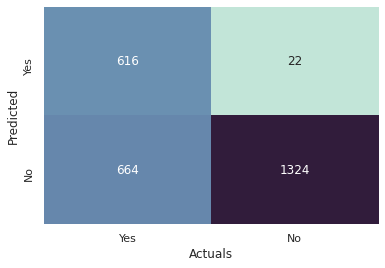

In [ ]:
## Confusion Matrix

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat.T, annot=True, fmt='d', cbar=False, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True),
          xticklabels=['Yes','No'],
          yticklabels=['Yes','No'] )
plt.xlabel('Actuals')
plt.ylabel('Predicted')

In [ ]:
# Kept aside some data to test - X_test
y_pred = rf.predict(X_test_scaled)

compare_df = pd.DataFrame({"Desired Output (Actuals)": y_test, 
                           "Predicted Output": y_pred})

In [ ]:
compare_df[:10]

,Desired Output (Actuals),Predicted Output
4075,1,1
397,0,0
11135,1,1
11920,1,1
11661,1,1
2894,0,0
6648,1,1
8133,1,1
3861,0,1
2976,0,0


In [ ]:
# List out the first twenty or less missed predictions
compared_bool = compare_df['Desired Output (Actuals)'] != compare_df['Predicted Output']
df_missed = compare_df[compared_bool]
df_missed[:10]

,Desired Output (Actuals),Predicted Output
3861,0,1
4495,0,1
8640,0,1
6623,0,1
9093,0,1
10970,1,0
5404,0,1
5710,0,1
4398,0,1
6366,0,1


###Future Prediction

In [ ]:
my_features = X_test.iloc[np.random.randint(0, len(X_test))]
own_pred = rf.predict(my_features.to_numpy().reshape(1,-1))
print("My prediction is a : " + str(own_pred))
print("This was the input data:")
print(my_features)

My prediction is a : [0]
This was the input data:
Warehouse_block_F             0.0
Mode_of_Shipment_Flight       0.0
Mode_of_Shipment_Road         0.0
Mode_of_Shipment_Ship         1.0
Product_importance            2.0
Cost_of_the_Product         145.0
Discount_offered              8.0
Weight_in_gms              5477.0
Name: 12045, dtype: float64
